In [14]:
import numpy as np
from Datasety.prophesee_automotive_dataset_toolbox_master.src.io.psee_loader import PSEELoader
events_file = "Datasety/Prophesee_Dataset_n_cars/n-cars_test/cars/obj_000600_td.dat"

# open a file
video = PSEELoader(events_file)
print(video)  # show some metadata
print(video.event_count())  # number of events in the file
print(video.total_time())  # duration of the file in mus
print(video.get_size())

PSEELoader:
-----------
Event Type: Event2D
Event Size: 8 bytes
Event Count: 2775
Duration: 0.09993199999999999 s 
-----------

2775
99932
[None, None]


In [15]:
# let's read some Events , there are two ways by number of events or by time slices
events = video.load_n_events(10)  # this loads the 10 next events
events

array([(  0, 19, 27, 0), (  6, 17, 36, 0), (  9, 40, 10, 0),
       ( 13, 67,  7, 1), ( 13, 16,  7, 1), ( 14, 64, 14, 1),
       ( 17, 63, 21, 1), ( 91, 68, 10, 0), ( 91, 16, 36, 0),
       (143, 46,  5, 0)],
      dtype=[('t', '<u4'), ('x', '<u2'), ('y', '<u2'), ('p', 'u1')])

In [16]:
print(events['t'])  # this shows only the timestamps of events
# for instance to count the events of positive polarity you can do :
np.sum(events['p'] > 0)

[  0   6   9  13  13  14  17  91  91 143]


4

In [17]:
while not video.done:
    # load events and boxes from all files
    events = video.load_delta_t(50000)
    # do something with the events
print(len(video.load_n_events(1)))

0


In [18]:
video.seek_event(0)

In [19]:
import cv2
def gausianBlur3D(pic):
    # gausian blur is seperatable
    c,x,y = pic.shape
    for channel in range(c):
        pic[channel,:,:] = cv2.GaussianBlur(pic[channel,:,:], (3,3) ,0)
    
    pic[0,:,:] = 0.5 * pic[0,:,:] + 0.25 * pic[1,:,:]
    for channel in range(1,c-1):
        pic[channel,:,:] = 0.5 * pic[channel,:,:] + 0.25 * pic[channel+1,:,:] + 0.25 * pic[channel-1,:,:]
    pic[-1,:,:] = 0.5 * pic[-1,:,:] + 0.25 * pic[-2,:,:]
    return pic

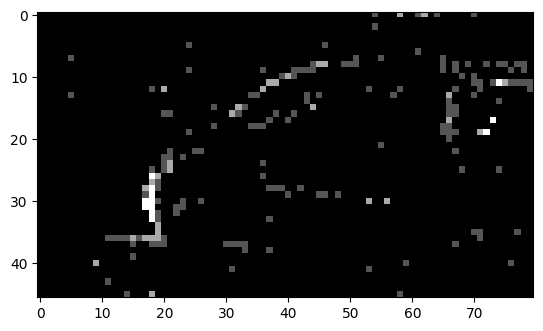

0.499984671461394


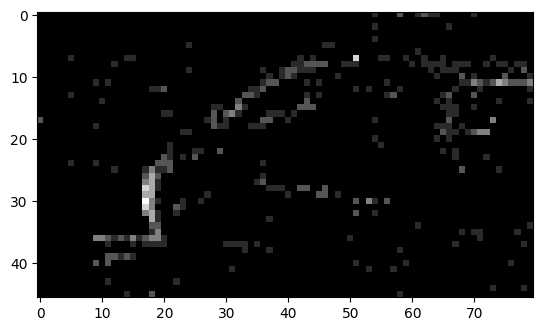

0.9999939462789245


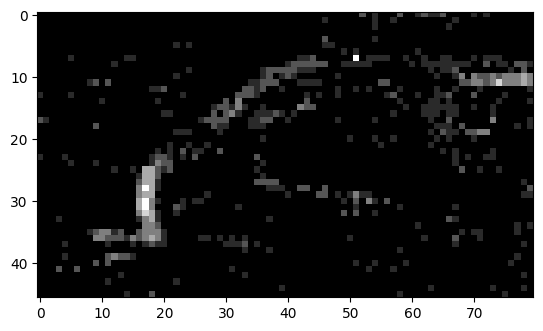

1.0


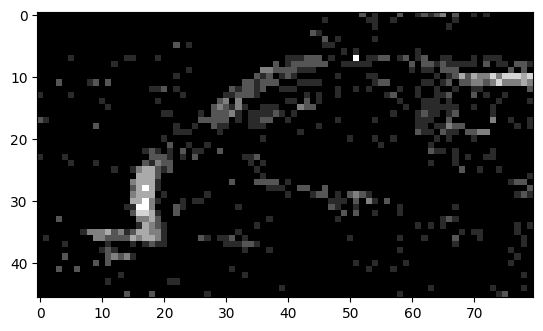

1.0


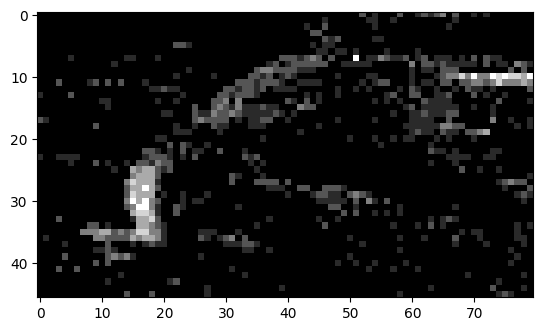

1.0


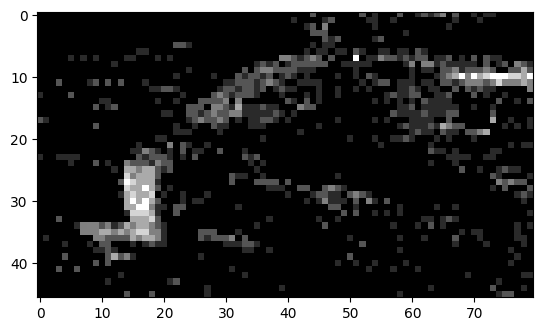

1.0


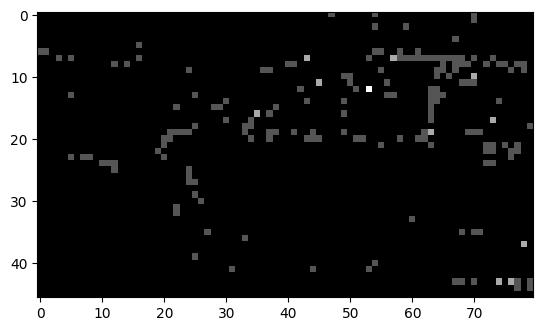

0.499991280244945


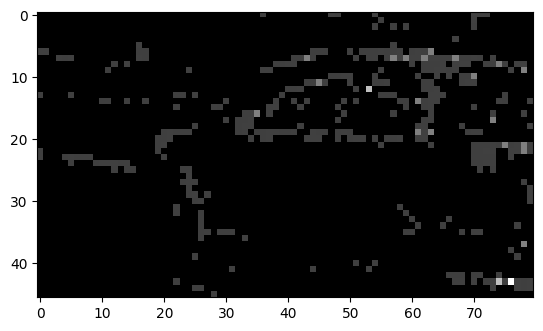

0.6666762277682992


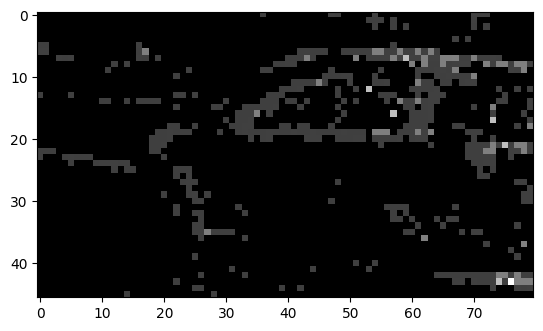

0.6667429440939313


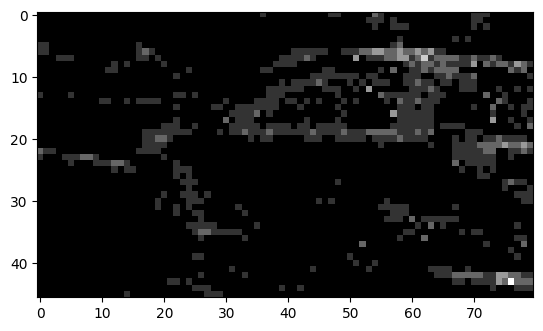

0.8334646272578975


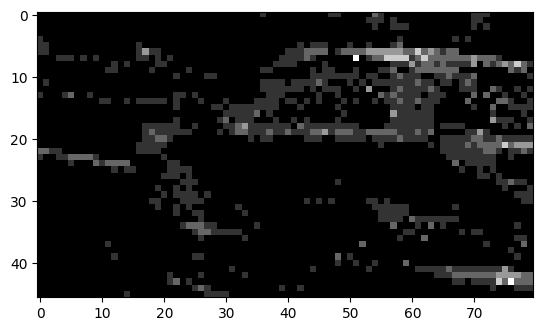

0.833548034607911


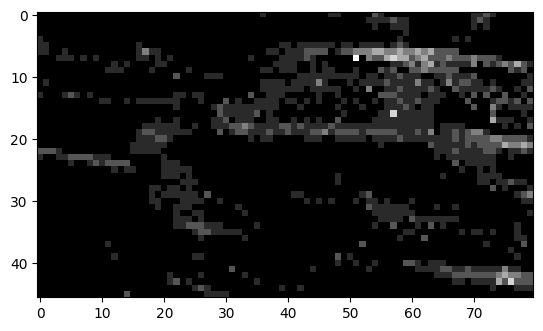

1.0
80 46


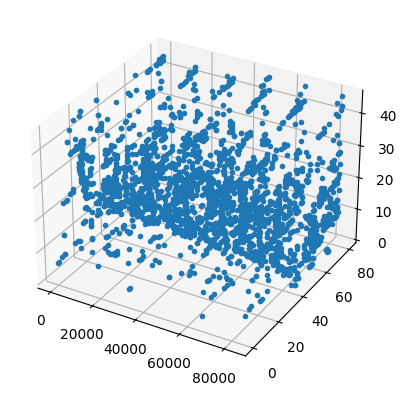

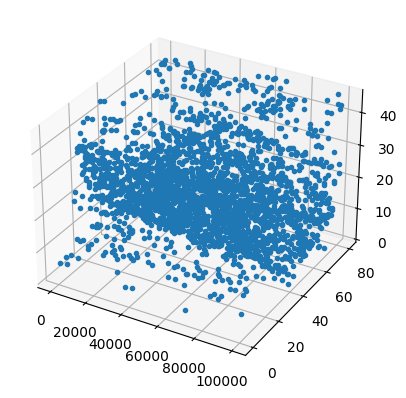

In [20]:
import cv2
import matplotlib.pyplot as plt
import scipy

video.seek_event(0)

while not video.done:
    # load events and boxes from all files
    size = video.event_count()
    events = video.load_n_events(size)
    # do something with the events
    noBins = 6
    tau = 0.6
    alpha = 0.1
    pic = np.zeros((2*noBins,128,128))
    pic3D = []
    pic3D_quantized = []
    temp_x = 0   
    temp_y = 0
    delta_t = (video.total_time()+0.00001)/noBins
    for event in events:
        t,x,y,p = event
        temp_x = max(temp_x, x)
        temp_y = max(temp_y, y)
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        # pic[int(np.floor(float(t)/delta_t)),y,x] = max(pic[int(np.floor(float(t)/delta_t)),y,x], 1)
        
        pic3D_quantized.append([int(np.floor(float(t)/delta_t)) * delta_t,x,y])
        pic3D.append([t,x,y])
    
    pic = np.array(pic)
    for i in range(2*noBins):
        pic2 = pic[i,:temp_y,:temp_x]
        plt.gray()
        plt.imshow(pic2)
        plt.show()
        print(np.max(pic2))



    ax = plt.figure().add_subplot(projection='3d')
    pic3D_quantized = np.array(pic3D_quantized)
    ax.plot(pic3D_quantized[:,0], pic3D_quantized[:,1], pic3D_quantized[:,2], '.')


    ax = plt.figure().add_subplot(projection='3d')
    pic3D = np.array(pic3D)
    ax.plot(pic3D[:,0], pic3D[:,1], pic3D[:,2], '.')
    print(temp_x, temp_y)


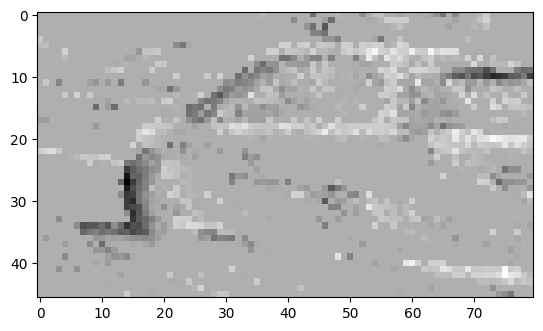

80 46


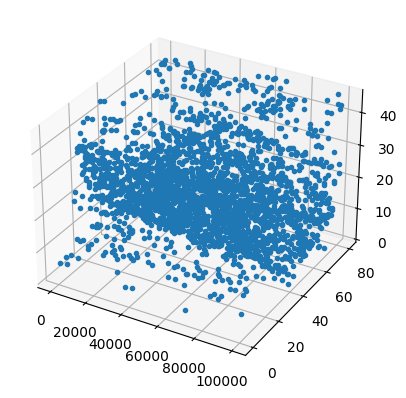

In [21]:
video.seek_event(0)
while not video.done:
    # load events and boxes from all files
    events = video.load_delta_t(100000)
    # do something with the events
    pic = np.ones((128,128))
    pic3D = []
    temp_x = 0   
    temp_y = 0
    for event in events:
        t,x,y,p = event
        temp_x = max(temp_x, x)
        temp_y = max(temp_y, y)
        pic[y,x] += t*(p-0.5)*2
        pic3D.append([t,x,y])

    pic = pic[:temp_y,:temp_x]
    plt.gray()
    plt.imshow(pic/3)
    plt.show()
    ax = plt.figure().add_subplot(projection='3d')
    pic3D = np.array(pic3D)
    ax.plot(pic3D[:,0], pic3D[:,1], pic3D[:,2], '.')
    print(temp_x, temp_y)

In [22]:
import os

test_dir = "Datasety/Prophesee_Dataset_n_cars/n-cars_test/cars/"
train_dir = "Datasety/Prophesee_Dataset_n_cars/n-cars_test/cars/"

for filename in os.listdir(train_dir):
    video = PSEELoader(train_dir + filename)
    events = video.load_delta_t(video.total_time()+1)
    max_x = np.max(events['x'])
    max_y = np.max(events['y'])


### Definicja datasetu

In [23]:
import os

import argparse
import pickle as pkl
from Dataset import Dataset
from model import *
import time
from copy import deepcopy

from tqdm import tqdm


In [24]:


test_dir_c = "Datasety/Prophesee_Dataset_n_cars/n-cars_test/cars/"
test_dir_b = "Datasety/Prophesee_Dataset_n_cars/n-cars_test/background/"
train_dir_c = "Datasety/Prophesee_Dataset_n_cars/n-cars_train/cars/"
train_dir_b = "Datasety/Prophesee_Dataset_n_cars/n-cars_train/background/"

noBins = 6
tau = 0.8
alpha = 0.1
train_x = []
train_y = []

test_x = []
test_y = []

for filename, _ in zip(os.listdir(train_dir_c),tqdm(range(len(os.listdir(train_dir_c))))):
    video = PSEELoader(train_dir_c + filename)
    events = video.load_delta_t(video.total_time()+1)
    max_x = np.max(events['x'])+1
    max_y = np.max(events['y'])+1
    delta_t = (video.total_time()+0.00001)/noBins
    pic = np.zeros((noBins*2,max_y,max_x),dtype= np.float32)
    for event in events:
        t,x,y,p = event
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        #pic[y,x] += t*(p-0.5)*2 #*t
    # pic = gausianBlur3D(pic)
    # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.transpose(pic, (1,2, 0))
    train_x.append(np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1)))
    train_y.append(1)

for filename, _ in zip(os.listdir(train_dir_b),tqdm(range(len(os.listdir(train_dir_b))))):
    video = PSEELoader(train_dir_b + filename)
    events = video.load_delta_t(video.total_time()+1)
    max_x = np.max(events['x'])+1
    max_y = np.max(events['y'])+1
    delta_t = (video.total_time()+0.00001)/noBins
    pic = np.zeros((2*noBins,max_y,max_x),dtype= np.float32)
    for event in events:
        t,x,y,p = event
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        # pic[y,x] += t*(p-0.5)*2 #*t
    # pic = gausianBlur3D(pic)
    # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.transpose(pic, (1,2, 0))
    train_x.append(np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1)))
    train_y.append(0)


train_x = np.array(train_x)

for filename, _ in zip(os.listdir(test_dir_c),tqdm(range(len(os.listdir(test_dir_c))))):
    video = PSEELoader(test_dir_c + filename)
    events = video.load_delta_t(video.total_time()+1)
    max_x = np.max(events['x'])+1
    max_y = np.max(events['y'])+1
    pic = np.zeros((2*noBins,max_y,max_x),dtype= np.float32)
    delta_t = (video.total_time()+0.00001)/noBins
    for event in events:
        t,x,y,p = event
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        # pic[y,x] += t*(p-0.5)*2 #*t
    # pic = gausianBlur3D(pic)
    # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.transpose(pic, (1,2, 0))
    test_x.append(np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1)))
    test_y.append(1)



for filename, _ in zip(os.listdir(test_dir_b),tqdm(range(len(os.listdir(test_dir_b))))):
    video = PSEELoader(test_dir_b + filename)
    events = video.load_delta_t(video.total_time()+1)
    max_x = np.max(events['x'])+1
    max_y = np.max(events['y'])+1
    pic = np.zeros((2*noBins,max_y,max_x),dtype= np.float32)
    delta_t = (video.total_time()+0.00001)/noBins
    for event in events:
        t,x,y,p = event
        for i in range(int(np.floor(float(t)/delta_t)), noBins):
            pic[i+(p*noBins),y,x] = min(pic[i+(p*noBins),y,x] + alpha*np.exp(((i*delta_t)-t)/((delta_t**2)*tau))/tau, 1)
        # pic[y,x] += t*(p-0.5)*2 #*t
    # pic = gausianBlur3D(pic)
    # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    normalized_image = np.transpose(pic, (1,2, 0))
    test_x.append(np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1)))
    test_y.append(0)



train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)

100%|█████████▉| 4210/4211 [05:00<00:00, 14.03it/s]


In [26]:
dir_dataset = "Datasety/"
np.save(dir_dataset + 'nCars_train_EST_exp__x.npy', train_x)
np.save(dir_dataset + 'nCars_train_EST_exp__y.npy', train_y)
np.save(dir_dataset + 'nCars_test_EST_exp__x.npy', test_x)
np.save(dir_dataset + 'nCars_test_EST_exp__y.npy', test_y)
